# Atividade Extra 03b - Difícil
## Segmentar e fazer Reconhecimento de Caracteres
### usando OpenCV 3


Veja links relacionados:

* http://www.shogun-toolbox.org/static/notebook/current/Sudoku_recognizer.html (reprodução neste Extra 03)
* http://opencvpython.blogspot.com.br/2012/06/sudoku-solver-part-2.html
* http://stackoverflow.com/questions/10196198/how-to-remove-convexity-defects-in-a-sudoku-square


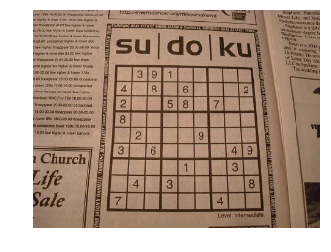

In [1]:
%matplotlib inline
import pylab as pl
import cv2 
import numpy as np 

#load image
image_sudoku_original = cv2.imread('extra03b_img.png')
image_sudoku_original=image_sudoku_original[12:234,30:323]


#Show Images
_=pl.imshow(image_sudoku_original) 
_=pl.axis("off")


# Step 1: Segmenting the Sudoku

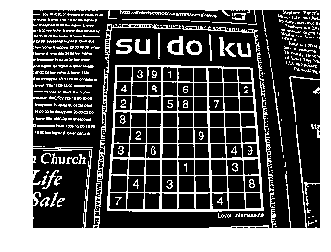

In [2]:
#gray image
image_sudoku_gray = cv2.cvtColor(image_sudoku_original,cv2.COLOR_BGR2GRAY)

#adaptive threshold
thresh = cv2.adaptiveThreshold(image_sudoku_gray,255,1,1,11,15)

#show image
_=pl.imshow(thresh, cmap=pl.gray())
_=pl.axis("off")

In [3]:
#find the countours 
#contours0, hierarchy = cv2.findContours( thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
_, contours0, hierarchy = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

#size of the image (height, width)
h, w = image_sudoku_original.shape[:2]

#copy the original image to show the posible candidate
image_sudoku_candidates = image_sudoku_original.copy()

#biggest rectangle
size_rectangle_max = 0; 
for i in range(len(contours0)):
    #aproximate countours to polygons
    approximation = cv2.approxPolyDP(contours0[i], 4, True)
        
    #has the polygon 4 sides?
    if(not (len (approximation)==4)):
        continue;
    #is the polygon convex ?
    if(not cv2.isContourConvex(approximation) ):
        continue; 
    #area of the polygon
    size_rectangle = cv2.contourArea(approximation)
    #store the biggest
    if size_rectangle> size_rectangle_max:
        size_rectangle_max = size_rectangle 
        big_rectangle = approximation

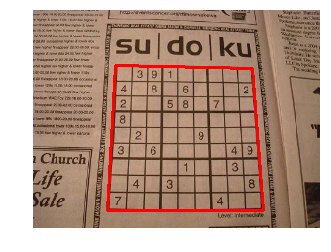

In [4]:
#show the best candidate
approximation = big_rectangle
for i in range(len(approximation)):
    cv2.line(image_sudoku_candidates,
             (big_rectangle[(i%4)][0][0], big_rectangle[(i%4)][0][1]), 
             (big_rectangle[((i+1)%4)][0][0], big_rectangle[((i+1)%4)][0][1]),
             (255, 0, 0), 2)
#show image
_=pl.imshow(image_sudoku_candidates, cmap=pl.gray()) 
_=pl.axis("off")

## perspectivetransform

In [5]:
IMAGE_WIDHT = 16
IMAGE_HEIGHT = 16
SUDOKU_SIZE= 9
N_MIN_ACTVE_PIXELS = 10

#sort the corners to remap the image
def getOuterPoints(rcCorners):
    ar = [];
    ar.append(rcCorners[0,0,:]);
    ar.append(rcCorners[1,0,:]);
    ar.append(rcCorners[2,0,:]);
    ar.append(rcCorners[3,0,:]);
    
    x_sum = sum(rcCorners[x, 0, 0] for x in range(len(rcCorners)) ) / len(rcCorners)
    y_sum = sum(rcCorners[x, 0, 1] for x in range(len(rcCorners)) ) / len(rcCorners)
    
    def algo(v):
        return (math.atan2(v[0] - x_sum, v[1] - y_sum)
                + 2 * math.pi) % 2*math.pi
        ar.sort(key=algo)
    return (  ar[3], ar[0], ar[1], ar[2])

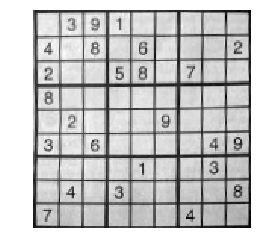

In [6]:
#point to remap
points1 = np.array([
                    np.array([0.0,0.0] ,np.float32) + np.array([144,0], np.float32),
                    np.array([0.0,0.0] ,np.float32),
                    np.array([0.0,0.0] ,np.float32) + np.array([0.0,144], np.float32),
                    np.array([0.0,0.0] ,np.float32) + np.array([144,144], np.float32),
                    ],np.float32)    
outerPoints = getOuterPoints(approximation)
points2 = np.array(outerPoints,np.float32)

#Transformation matrix
pers = cv2.getPerspectiveTransform(points2,  points1 );

#remap the image
warp = cv2.warpPerspective(image_sudoku_original, pers, (SUDOKU_SIZE*IMAGE_HEIGHT, SUDOKU_SIZE*IMAGE_WIDHT));
warp_gray = cv2.cvtColor(warp, cv2.COLOR_BGR2GRAY)

#show image
_=pl.imshow(warp_gray, cmap=pl.gray())
_=pl.axis("off")

# Step 2: Segmenting the numbers

In [7]:
def extract_number(x, y):
    #square -> position x-y
    im_number = warp_gray[x*IMAGE_HEIGHT:(x+1)*IMAGE_HEIGHT][:, y*IMAGE_WIDHT:(y+1)*IMAGE_WIDHT]

    #threshold
    im_number_thresh = cv2.adaptiveThreshold(im_number,255,1,1,15,9)
    #delete active pixel in a radius (from center) 
    for i in range(im_number.shape[0]):
        for j in range(im_number.shape[1]):
            dist_center = math.sqrt( (IMAGE_WIDHT/2 - i)**2  + (IMAGE_HEIGHT/2 - j)**2);
            if dist_center > 6:
                im_number_thresh[i,j] = 0;

    n_active_pixels = cv2.countNonZero(im_number_thresh)
    return [im_number, im_number_thresh, n_active_pixels]

In [8]:
def find_biggest_bounding_box(im_number_thresh):
    #contour,hierarchy = cv2.findContours(im_number_thresh.copy(),cv2.RETR_CCOMP,cv2.CHAIN_APPROX_SIMPLE)
    _, contour, hierarchy = cv2.findContours(im_number_thresh.copy(), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

    biggest_bound_rect = [];
    bound_rect_max_size = 0;
    for i in range(len(contour)):
        bound_rect = cv2.boundingRect(contour[i])
        size_bound_rect = bound_rect[2]*bound_rect[3]
        if  size_bound_rect  > bound_rect_max_size:
            bound_rect_max_size = size_bound_rect
            biggest_bound_rect = bound_rect
            
    #bounding box a little more bigger
    x_b, y_b, w, h = biggest_bound_rect;
    x_b= x_b-1;
    y_b= y_b-1;
    w = w+2;
    h = h+2; 
                
    return [x_b, y_b, w, h]

In [9]:
import math

#sudoku representation
sudoku = np.zeros(shape=(9*9,IMAGE_WIDHT*IMAGE_HEIGHT))

def Recognize_number( x, y):
    """
    Recognize the number in the rectangle
    """    
    #extract the number (small squares)
    [im_number, im_number_thresh, n_active_pixels] = extract_number(x, y)

    if n_active_pixels> N_MIN_ACTVE_PIXELS:
        [x_b, y_b, w, h] = find_biggest_bounding_box(im_number_thresh)

        im_t = cv2.adaptiveThreshold(im_number,255,1,1,15,9);
        number = im_t[y_b:y_b+h, x_b:x_b+w]

        if number.shape[0]*number.shape[1]>0:
            number = cv2.resize(number, (IMAGE_WIDHT, IMAGE_HEIGHT), interpolation=cv2.INTER_LINEAR)
            ret,number2 = cv2.threshold(number, 127, 255, 0)
            number = number2.reshape(1, IMAGE_WIDHT*IMAGE_HEIGHT)
            sudoku[x*9+y, :] = number;
            return 1

        else:
            sudoku[x*9+y, :] = np.zeros(shape=(1, IMAGE_WIDHT*IMAGE_HEIGHT));
            return 0

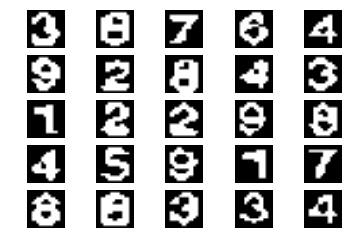

In [10]:
index_subplot=0
n_numbers=0
indexes_numbers = []
for i in range(SUDOKU_SIZE):
    for j in range(SUDOKU_SIZE):
        if Recognize_number(i, j)==1:
            if (n_numbers%5)==0:
                index_subplot=index_subplot+1
            indexes_numbers.insert(n_numbers, i*9+j)
            n_numbers=n_numbers+1

#create subfigures
f,axarr= pl.subplots(index_subplot,5)

width = 0;
for i in range(len(indexes_numbers)):
    ind = indexes_numbers[i]
    if (i%5)==0 and i!=0:
        width=width+1
    axarr[i%5, width].imshow(cv2.resize(sudoku[ind, :].reshape(IMAGE_WIDHT,IMAGE_HEIGHT), (IMAGE_WIDHT*5,IMAGE_HEIGHT*5)), cmap=pl.gray())
    axarr[i%5, width].axis("off")

# Muito difícil!
# 1)Tente reconhecer esses números usando o OpenCV 3
# 2) Tente resolver o sudoku

Obs.: Não consegui instalar a biblioteca Shogun no python 3...